Epoch 10/80, Loss: 0.2500, Accuracy: 0.4728
Epoch 20/80, Loss: 0.2500, Accuracy: 0.5644
Epoch 30/80, Loss: 0.2500, Accuracy: 0.6262
Epoch 40/80, Loss: 0.2499, Accuracy: 0.6782
Epoch 50/80, Loss: 0.2499, Accuracy: 0.7252
Epoch 60/80, Loss: 0.2499, Accuracy: 0.7748
Epoch 70/80, Loss: 0.2499, Accuracy: 0.7995
Epoch 80/80, Loss: 0.2499, Accuracy: 0.8144
Accuracy: 0.84
Precision: 0.9090909090909091
Recall: 0.7692307692307693

Matrice de confuzie:
                    Predicție Negativ (0)  Predicție Pozitiv (1)
Adevărat Negativ (0)      44                   4                   
Adevărat Pozitiv (1)      12                   40                  

Explicație:
True Negative (TN): 44 - Corect clasificate ca negativ
False Positive (FP): 4 - Incorect clasificate ca pozitiv
False Negative (FN): 12 - Incorect clasificate ca negativ
True Positive (TP): 40 - Corect clasificate ca pozitiv

Sentimentul mesajului 'By choosing a bike over a car, I’m reducing my environmental footprint. Cycling promotes ec

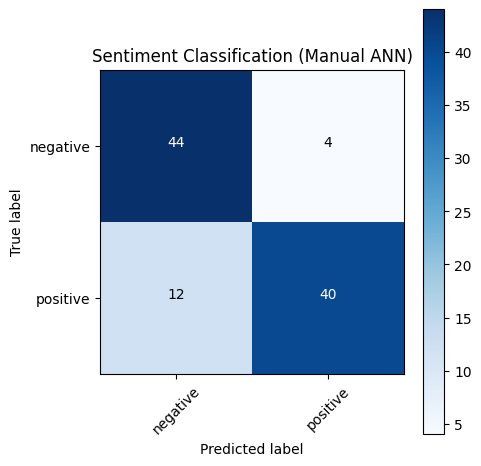

In [8]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE

# data preprocessing function
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        return text
    return ''

# load eco_500_sentences.csv
def loadTextData(file_path):
    data = pd.read_csv(file_path)
    data['Text'] = data['Text'].apply(clean_text)
    data = data[data['Text'] != ''].dropna()
    data['Sentiment'] = data['Sentiment'].map({'positive': 1, 'negative': 0})
    texts = data['Text'].values
    labels = data['Sentiment'].values
    output_names = ['negative', 'positive']
    return texts, labels, output_names

# split data into train/test
def splitData(inputs, outputs):
    np.random.seed(5)
    X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=5)
    return X_train, y_train, X_test, y_test

# manual ANN implementation
class ManualANN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        np.random.seed(1)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

    def relu(self, x):
        return np.maximum(0, x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def forward(self, X):
        hidden = self.relu(np.dot(X, self.W1) + self.b1)
        output = self.sigmoid(np.dot(hidden, self.W2) + self.b2)
        return output

    def train_step(self, X, y):
        m = X.shape[0]
        y = y.reshape(-1, 1)
        hidden = self.relu(np.dot(X, self.W1) + self.b1)
        output = self.sigmoid(np.dot(hidden, self.W2) + self.b2)
        error = output - y
        dW2 = np.dot(hidden.T, error) / m
        db2 = np.sum(error, axis=0, keepdims=True) / m
        error_hidden = np.dot(error, self.W2.T) * (hidden > 0).astype(float)
        dW1 = np.dot(X.T, error_hidden) / m
        db1 = np.sum(error_hidden, axis=0, keepdims=True) / m
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        return np.mean((y - output) ** 2)

    def fit(self, X, y, max_iter=80, verbose=2):
        for epoch in range(max_iter):
            loss = self.train_step(X, y)
            if verbose > 1 and (epoch + 1) % 10 == 0:
                output = self.forward(X)
                predictions = (output >= 0.5).astype(int).flatten()
                accuracy = np.mean(predictions == y)
                print(f'Epoch {epoch + 1}/{max_iter}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

    def predict(self, X):
        output = self.forward(X)
        return (output >= 0.5).astype(int).flatten()

# evaluation and plotting functions
def evalMultiClass(true_labels, predicted_labels, output_names):
    cm = confusion_matrix(true_labels, predicted_labels)
    acc = accuracy_score(true_labels, predicted_labels)
    prec, recall, _, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')
    return acc, prec, recall, cm

def plotConfusionMatrix(cm, output_names, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(output_names))
    plt.xticks(tick_marks, output_names, rotation=45)
    plt.yticks(tick_marks, output_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment="center",
                     color="white" if cm[i, j] > cm.max()/2 else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')

# function to predict sentiment of a single text
def predict_text_sentiment(text, vectorizer, model, output_names):
    cleaned_text = clean_text(text)
    text_features = vectorizer.transform([cleaned_text]).toarray()
    prediction = model.predict(text_features)
    sentiment = output_names[prediction[0]]
    return sentiment

# main execution
file_path = 'eco_500_sentences.csv'
texts, outputs, output_names = loadTextData(file_path)

# vectorize texts using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
trainInputs, trainOutputs, testInputs, testOutputs = splitData(texts, outputs)
trainFeatures = vectorizer.fit_transform(trainInputs).toarray()
testFeatures = vectorizer.transform(testInputs).toarray()

# apply SMOTE to balance classes
smote = SMOTE(random_state=42)
trainFeatures_balanced, trainOutputs_balanced = smote.fit_resample(trainFeatures, trainOutputs)

# train and evaluate the model
input_size = trainFeatures_balanced.shape[1]
hidden_size = 100
output_size = 1
classifier = ManualANN(input_size, hidden_size, output_size, learning_rate=0.05)
classifier.fit(trainFeatures_balanced, trainOutputs_balanced, max_iter=80, verbose=2)

predictedLabels = classifier.predict(testFeatures)

acc, prec, recall, cm = evalMultiClass(testOutputs, predictedLabels, output_names)
plotConfusionMatrix(cm, output_names, "Sentiment Classification (Manual ANN)")
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', recall)

# print confusion matrix as a table
print("\nMatrice de confuzie:")
print("                    Predicție Negativ (0)  Predicție Pozitiv (1)")
print(f"Adevărat Negativ (0)      {cm[0,0]:<20} {cm[0,1]:<20}")
print(f"Adevărat Pozitiv (1)      {cm[1,0]:<20} {cm[1,1]:<20}")
print("\nExplicație:")
print(f"True Negative (TN): {cm[0,0]} - Corect clasificate ca negativ")
print(f"False Positive (FP): {cm[0,1]} - Incorect clasificate ca pozitiv")
print(f"False Negative (FN): {cm[1,0]} - Incorect clasificate ca negativ")
print(f"True Positive (TP): {cm[1,1]} - Corect clasificate ca pozitiv")

# predict sentiment for a new text
sample_text = "By choosing a bike over a car, I’m reducing my environmental footprint. Cycling promotes eco-friendly transportation, and I’m proud to be part of that movement."
predicted_sentiment = predict_text_sentiment(sample_text, vectorizer, classifier, output_names)
print(f"\nSentimentul mesajului '{sample_text}' este: {predicted_sentiment}")